# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from datetime import date, timedelta
from tqdm import tqdm
import time
import datetime
%matplotlib inline
sns.set_style('dark')

In [3]:
train_pre = pd.read_csv('Data/初赛/train.csv')
test_pre = pd.read_csv('Data/初赛/test.csv')
answer_pre = pd.read_csv('Data/初赛/answer.csv')
answer_pre.columns = ['timestamp', 'temp_in']
train_pre.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in', 'temp_in']
test_pre.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in']
test_pre = pd.merge(test_pre, answer_pre, on='timestamp', how='left')
test_pre.temp_in.fillna(31.5, inplace=True)
train_pre['time'] = pd.to_datetime(train_pre[['year', 'month', 'day', 'hour', 'minute']])
test_pre['time'] = pd.to_datetime(test_pre[['year', 'month', 'day', 'hour', 'minute']])
data_pre = pd.concat([train_pre, test_pre])

train_final = pd.read_csv('Data/复赛/train.csv')
test_final = pd.read_csv('Data/复赛/test.csv')
sample_final = pd.read_csv('Data/复赛/提交样例.csv')
train_final.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in', 'temp_in']
test_final.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in']
sample_final.columns = ['timestamp', 'temp_in']
train_final['time'] = pd.to_datetime(train_final[['year', 'month', 'day', 'hour', 'minute']])
test_final = pd.merge(sample_final[['timestamp']], test_final, on='timestamp', how='left')
test_final['time'] = pd.to_datetime(test_final[['year', 'month', 'day', 'hour', 'minute']])
test_final['time'] = [datetime.datetime.fromtimestamp(x) for x in test_final['timestamp']]
test_final['year'] = test_final.time.dt.year
test_final['month'] = test_final.time.dt.month
test_final['day'] = test_final.time.dt.day
test_final['hour'] = test_final.time.dt.hour
test_final['minute'] = test_final.time.dt.minute
test_final['second'] = test_final.time.dt.second


Preliminary:

- train: 2019-3-14 01:00 ~ 2019-4-3 00:59 per min
- test: 2019-4-3 01:00 ~ 2019-4-13 00:57 per 30mins

Final:
- train: 2020-01-13 00:00 ~ 2020-01-22 23:59 per min
- test: 2020-02-01 00:10 ~ 2020-02-05 22:10 per 2hoursto_datetime

## 填充每一分钟

In [4]:
time = {'year': [], 'month': [], 'day': [], 'hour': [], 'minute': []}
for day in range(14, 32):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2019)
            time['month'].append(3)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

for day in range(1, 3):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2019)
            time['month'].append(4)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

full_time = pd.DataFrame(time)
full_time['time'] = pd.to_datetime(full_time[['year', 'month', 'day', 'hour', 'minute']])
train_pre_full = full_time.loc[(full_time.time >= '2019-3-14 01') & (full_time.time < '2019-4-3 01'), :]

train_pre = pd.merge(train_pre_full, train_pre, on=['year', 'month', 'day', 'hour', 'minute', 'time'], how='left')
train_pre.drop(['second'], axis=1, inplace=True)
train_pre.drop_duplicates(['month', 'day', 'hour', 'minute'], inplace=True)
train_pre.reset_index(inplace=True, drop=True)

In [5]:
time = {'year': [], 'month': [], 'day': [], 'hour': [], 'minute': []}
for day in range(13, 23):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2020)
            time['month'].append(1)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

full_time = pd.DataFrame(time)
full_time['time'] = pd.to_datetime(full_time[['year', 'month', 'day', 'hour', 'minute']])

train_final = pd.merge(full_time, train_final, on=['year', 'month', 'day', 'hour', 'minute', 'time'], how='left')
train_final.drop(['second'], axis=1, inplace=True)
train_final.drop_duplicates(['month', 'day', 'hour', 'minute'], inplace=True)
train_final.reset_index(inplace=True, drop=True)

## 异常值处理

In [6]:
train_pre.fillna(method='ffill', inplace=True)
train_final.fillna(method='ffill', inplace=True)

In [7]:
for feat in ['hum_out', 'hum_in', 'air_out', 'air_in']:
    for df in [train_pre, train_final]:
        lower, upper = np.percentile(df[feat], (3, 97))
        df.loc[(df[feat] < lower) | (df[feat] > upper), feat] = np.NaN

In [8]:
train_pre.fillna(method='ffill', inplace=True)
train_final.fillna(method='ffill', inplace=True)

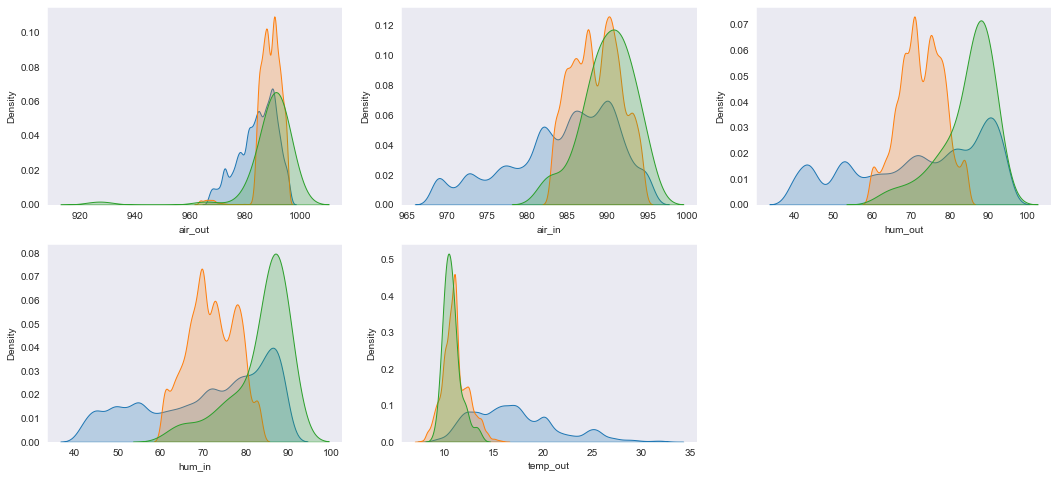

In [9]:
cols = ['air_out', 'air_in', 'hum_out', 'hum_in', 'temp_out']
plt.figure(figsize=(18,8))
for i in range(5):
    plt.subplot(2,3,i+1)
    sns.kdeplot(train_pre[cols[i]], shade=True, label='2019 train '+cols[i])
    sns.kdeplot(train_final[cols[i]], shade=True, label='2020 train '+cols[i])
    sns.kdeplot(test_final[cols[i]], shade=True, label='2020 test '+cols[i])

## 特征工程

In [10]:
day = 24*60*60
hour = 60*60
minute = 60
for df in [train_final, test_final]:
    df['day sin'] = np.sin(df['timestamp'] * (2 * np.pi / day))
    df['day cos'] = np.cos(df['timestamp'] * (2 * np.pi / day))
    df['hour sin'] = np.sin(df['timestamp'] * (2 * np.pi / hour))
    df['hour cos'] = np.cos(df['timestamp'] * (2 * np.pi / hour))
    df['minute sin'] = np.sin(df['timestamp'] * (2 * np.pi / minute))
    df['minute cos'] = np.cos(df['timestamp'] * (2 * np.pi / minute))

## Split the data

In [11]:
features = ['temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in', 'temp_in', 'day sin', 'day cos', 'hour sin', 'hour cos', 'minute sin', 'minute cos']
train_final = train_final[features]
column_indices = {name: i for i, name in enumerate(features)}

n = len(train_final)
train_df = train_final[0:int(n*0.7)].copy()
val_df = train_final[int(n*0.7):int(n*0.9)].copy()
test_df = train_final[int(n*0.9):].copy()

num_features = train_final.shape[1]

## Normalize the data

In [12]:
train_mean = train_df[cols].mean()
train_std = train_df[cols].std()

train_df.loc[:, cols] = (train_df[cols] - train_mean) / train_std
val_df.loc[:, cols] = (val_df[cols] - train_mean) / train_std
test_df.loc[:, cols] = (test_df[cols] - train_mean) / train_std

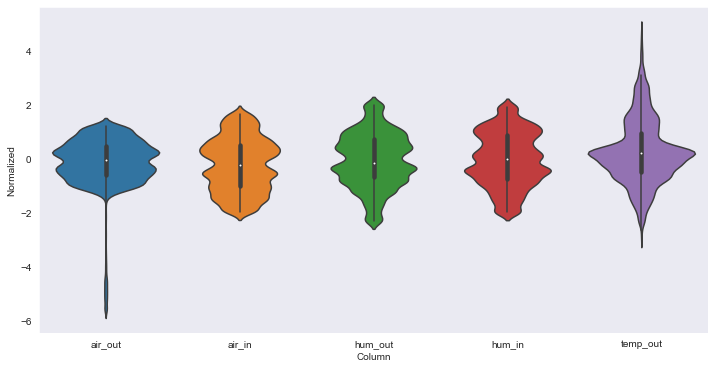

In [13]:
df_std = (train_final[cols] - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_final[cols].keys())

# Data Window

In [14]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [15]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['hum_out'])